The main objective of this dataset is to predict car prices,

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from scipy.stats import zscore
from itertools import combinations_with_replacement


## Download Dataset

In [3]:
# !kaggle datasets download ahmedwaelnasef/cars-dataset

In [4]:
# import zipfile

# with zipfile.ZipFile('cars-dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('cars-dataset')

## Import Dataset

In [5]:
car_df = pd.read_csv('cars-dataset/cars.csv')

In [6]:
car_df.head()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
0,Fiat 500e 2021 La Prima,TBD,0.0,"N/A, Electric",Single,Automatic,150,fiat,ksa
1,Peugeot Traveller 2021 L3 VIP,"SAR 140,575",2.0,4,180,8 Seater,8.8,peugeot,ksa
2,Suzuki Jimny 2021 1.5L Automatic,"SAR 98,785",1.5,4,102,145,4 Seater,suzuki,ksa
3,Ford Bronco 2021 2.3T Big Bend,"SAR 198,000",2.3,4,420,4 Seater,7.5,ford,ksa
4,Honda HR-V 2021 1.8 i-VTEC LX,Orangeburst Metallic,1.8,4,140,190,5 Seater,honda,ksa


In [7]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   car name         6308 non-null   object
 1   price            6308 non-null   object
 2   engine_capacity  6308 non-null   object
 3   cylinder         5684 non-null   object
 4   horse_power      6308 non-null   object
 5   top_speed        6308 non-null   object
 6   seats            6308 non-null   object
 7   brand            6308 non-null   object
 8   country          6308 non-null   object
dtypes: object(9)
memory usage: 443.7+ KB


In [8]:
car_df.describe()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country
count,6308,6308,6308,5684,6308,6308,6308,6308,6308
unique,2546,3395,129,10,330,169,82,82,7
top,Mercedes-Benz C-Class 2022 C 300,TBD,2.0,4,150,250,5 Seater,mercedes-benz,uae
freq,10,437,1241,2856,162,1100,3471,560,1248


In [9]:
print(car_df.columns)

Index(['car name', 'price', 'engine_capacity', 'cylinder', 'horse_power',
       'top_speed', 'seats', 'brand', 'country'],
      dtype='object')


In [10]:
currencies=set()

for price in car_df['price']:
    if not any(chr.isdigit() for chr in price):
        car_df['price'] = car_df['price'].replace(price, -1)
    else:
            currencies.add(price.split(' ')[0])



In [11]:
currencies

{'AED', 'BHD', 'EGP', 'F8', 'KWD', 'OMR', 'QAR', 'SAR'}

In [12]:
exchange_rates = {
    'AED': 3.6725,  # 1 USD = 3.6725 AED
    'BHD': 0.377,   # 1 USD = 0.377 BHD
    'EGP': 30.22,   # 1 USD = 30.22 EGP
    'KWD': 0.308,   # 1 USD = 0.308 KWD
    'OMR': 0.384,   # 1 USD = 0.384 OMR
    'QAR': 3.64,    # 1 USD = 3.64 QAR
    'SAR': 3.75     # 1 USD = 3.75 SAR
}


In [13]:
converted_prices = []

for price in car_df['price']:
    if price == -1:
        converted_prices.append(np.nan)
    else:
        currency = price.split(' ')[0]
        try:
            price_value = float(price.split(' ')[1].replace(',', '')) # remove the comma in the number
            converted_price = price_value / exchange_rates[currency]
            #add only 3 digits after the decimal point
            converted_price = round(converted_price, 3)
            converted_prices.append(converted_price)
        except (ValueError, IndexError):
            converted_prices.append(np.nan)

car_df['price_usd'] = converted_prices
car_df.drop('price', axis=1, inplace=True)

In [14]:
car_df

,car name,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country,price_usd
0,Fiat 500e 2021 La Prima,0.0,"N/A, Electric",Single,Automatic,150,fiat,ksa,NaN
1,Peugeot Traveller 2021 L3 VIP,2.0,4,180,8 Seater,8.8,peugeot,ksa,37486.667
2,Suzuki Jimny 2021 1.5L Automatic,1.5,4,102,145,4 Seater,suzuki,ksa,26342.667
3,Ford Bronco 2021 2.3T Big Bend,2.3,4,420,4 Seater,7.5,ford,ksa,52800.000
4,Honda HR-V 2021 1.8 i-VTEC LX,1.8,4,140,190,5 Seater,honda,ksa,NaN
...,...,...,...,...,...,...,...,...,...
6303,Bentley Mulsanne 2021 6.75L V8 Extended Wheelbase,6.8,8,505,296,5 Seater,bentley,uae,NaN
6304,Ferrari SF90 Stradale 2021 4.0T V8 Plug-in-Hybrid,4.0,8,25,800,Automatic,ferrari,uae,480898.570
6305,Rolls Royce Wraith 2021 6.6L Base,6.6,12,624,250,4 Seater,rolls-royce,uae,381211.709
6306,Lamborghini Aventador S 2021 6.5L V12 Coupe,6.5,NaN,740,350,2 Seater,lamborghini,uae,449285.228


In [15]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   car name         6308 non-null   object 
 1   engine_capacity  6308 non-null   object 
 2   cylinder         5684 non-null   object 
 3   horse_power      6308 non-null   object 
 4   top_speed        6308 non-null   object 
 5   seats            6308 non-null   object 
 6   brand            6308 non-null   object 
 7   country          6308 non-null   object 
 8   price_usd        4979 non-null   float64
dtypes: float64(1), object(8)
memory usage: 443.7+ KB


In [16]:
car_df['price_usd'].describe()

count    4.979000e+03
mean     7.222527e+04
std      1.069692e+05
min      4.765056e+03
25%      2.568890e+04
50%      4.752604e+04
75%      8.385989e+04
max      3.550613e+06
Name: price_usd, dtype: float64

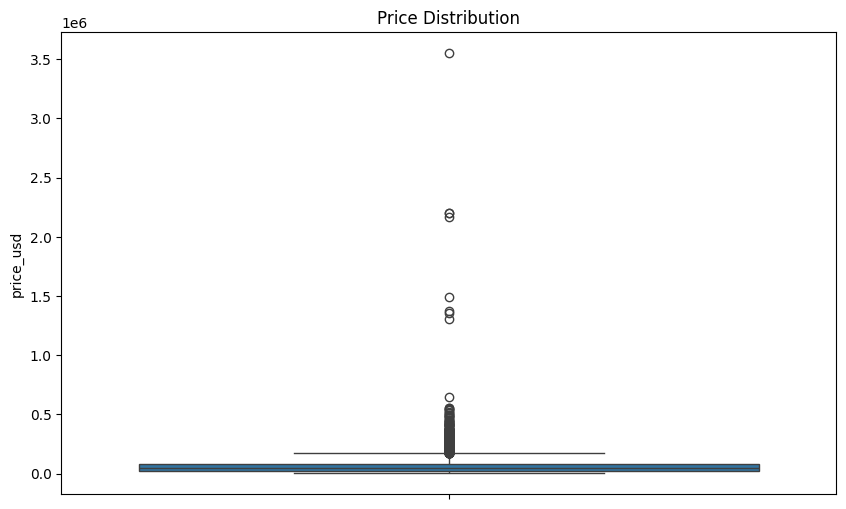

In [17]:
# draw boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y=car_df['price_usd'])
plt.title('Price Distribution')
plt.show()

In [18]:
#handling outliers
# drop any row that has a price greater than 3M USD
car_df = car_df[car_df['price_usd'] < 3000000]


In [19]:
car_df['price_usd'].describe()
# from 4700 to 2.2M USD 

count    4.978000e+03
mean     7.152652e+04
std      9.493792e+04
min      4.765056e+03
25%      2.568176e+04
50%      4.750307e+04
75%      8.374334e+04
max      2.200604e+06
Name: price_usd, dtype: float64

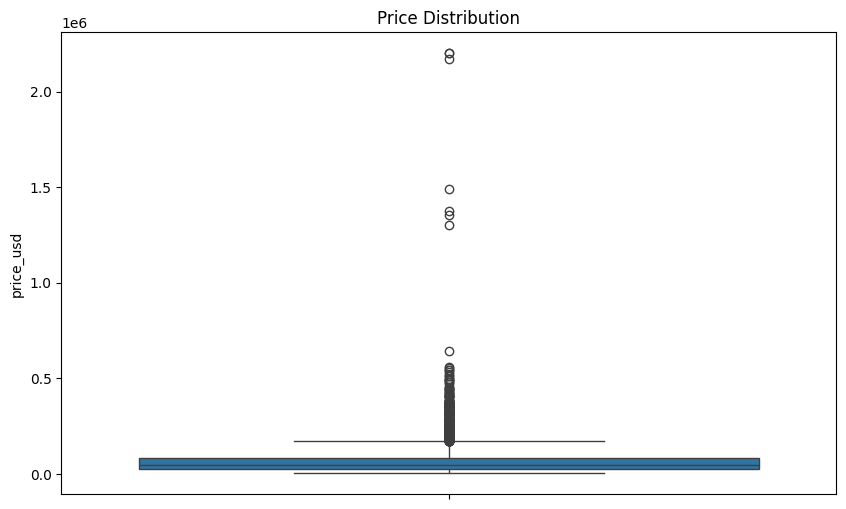

In [20]:
#draw boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y=car_df['price_usd'])
plt.title('Price Distribution')
plt.show()

In [21]:
engine_capacities = []

for val in car_df['engine_capacity']:
    try:
        val = float(val)
        if val <= 0:
            engine_capacities.append(np.nan)
        elif val < 10:
            engine_capacities.append(val * 1000)
        else:
            engine_capacities.append(val)

    except ValueError: # if the value is not a number
        print(val)
        engine_capacities.append(np.nan)

car_df['engine_capacity_edited'] = engine_capacities

car_df.drop('engine_capacity', axis=1, inplace=True)
#


Cylinders


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16184\3974221890.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['engine_capacity_edited'] = engine_capacities
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16184\3974221890.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df.drop('engine_capacity', axis=1, inplace=True)


In [22]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4978 entries, 1 to 6306
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                4978 non-null   object 
 1   cylinder                4447 non-null   object 
 2   horse_power             4978 non-null   object 
 3   top_speed               4978 non-null   object 
 4   seats                   4978 non-null   object 
 5   brand                   4978 non-null   object 
 6   country                 4978 non-null   object 
 7   price_usd               4978 non-null   float64
 8   engine_capacity_edited  4933 non-null   float64
dtypes: float64(2), object(7)
memory usage: 388.9+ KB


In [23]:
car_df['engine_capacity_edited'].describe()

count    4933.000000
mean     2810.422258
std      1281.450994
min       140.000000
25%      2000.000000
50%      2500.000000
75%      3500.000000
max      6800.000000
Name: engine_capacity_edited, dtype: float64

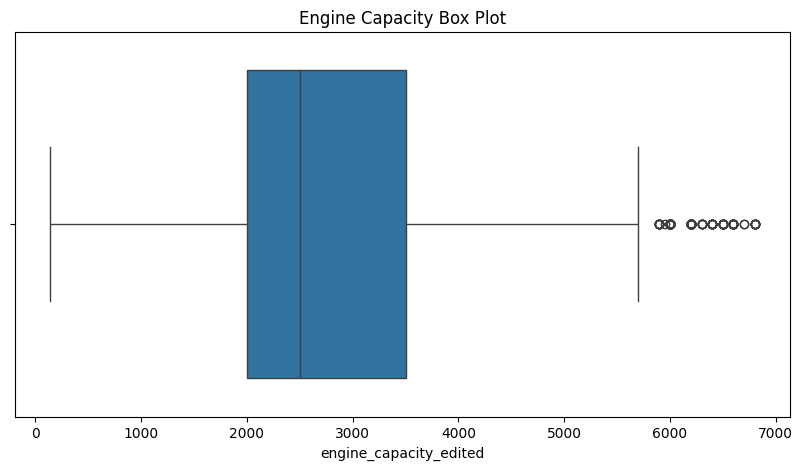

In [24]:

# draw box plot 
plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['engine_capacity_edited'])
plt.title('Engine Capacity Box Plot')
plt.show()

    

In [25]:
# the engine capacity is in cubic centimeters can be from 600 to 8000 cm^3

car_df = car_df[(car_df['engine_capacity_edited'] >= 600) & (car_df['engine_capacity_edited'] <= 8000)]


In [26]:

car_df['engine_capacity_edited'].describe()

count    4932.000000
mean     2810.963706
std      1281.016466
min       999.000000
25%      2000.000000
50%      2500.000000
75%      3500.000000
max      6800.000000
Name: engine_capacity_edited, dtype: float64

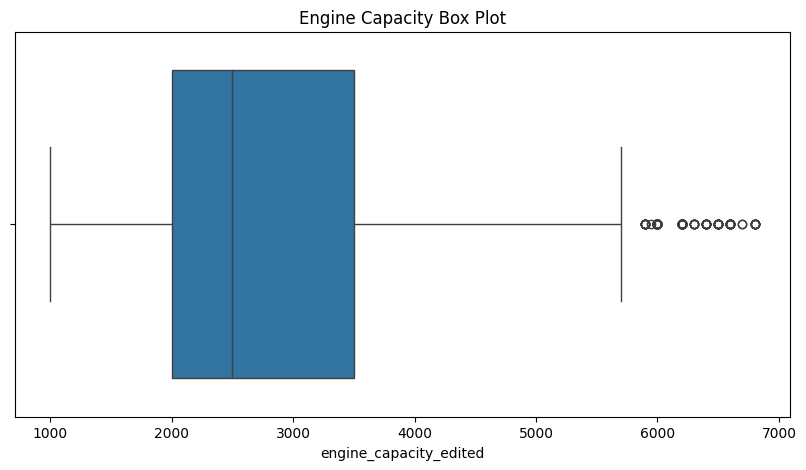

In [27]:
# draw box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['engine_capacity_edited'])
plt.title('Engine Capacity Box Plot')
plt.show()

In [28]:
car_df.head()

,car name,cylinder,horse_power,top_speed,seats,brand,country,price_usd,engine_capacity_edited
1,Peugeot Traveller 2021 L3 VIP,4,180,8 Seater,8.8,peugeot,ksa,37486.667,2000.0
2,Suzuki Jimny 2021 1.5L Automatic,4,102,145,4 Seater,suzuki,ksa,26342.667,1500.0
3,Ford Bronco 2021 2.3T Big Bend,4,420,4 Seater,7.5,ford,ksa,52800.000,2300.0
5,Honda HR-V 2021 1.8 i-VTEC EX,4,140,190,5 Seater,honda,ksa,25422.667,1800.0
6,Peugeot Expert 2021 Van L3 A/T,4,120,170,N A,peugeot,ksa,22092.000,2000.0


In [29]:
cylinders = []
c = set()
for cylinder in car_df['cylinder']:
    try:
        cylinder=int(cylinder)

        if cylinder <= 0:
            cylinders.append(np.nan)
        else:
            cylinders.append(cylinder)
    except ValueError:
        cylinders.append(np.nan)

car_df['cylinder_edited'] = cylinders
# make int type
car_df.drop('cylinder', axis=1, inplace=True)

In [30]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4932 entries, 1 to 6306
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                4932 non-null   object 
 1   horse_power             4932 non-null   object 
 2   top_speed               4932 non-null   object 
 3   seats                   4932 non-null   object 
 4   brand                   4932 non-null   object 
 5   country                 4932 non-null   object 
 6   price_usd               4932 non-null   float64
 7   engine_capacity_edited  4932 non-null   float64
 8   cylinder_edited         4401 non-null   float64
dtypes: float64(3), object(6)
memory usage: 385.3+ KB


In [31]:

car_df['cylinder_edited'].describe()

count    4401.000000
mean        5.312429
std         1.900084
min         3.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        12.000000
Name: cylinder_edited, dtype: float64

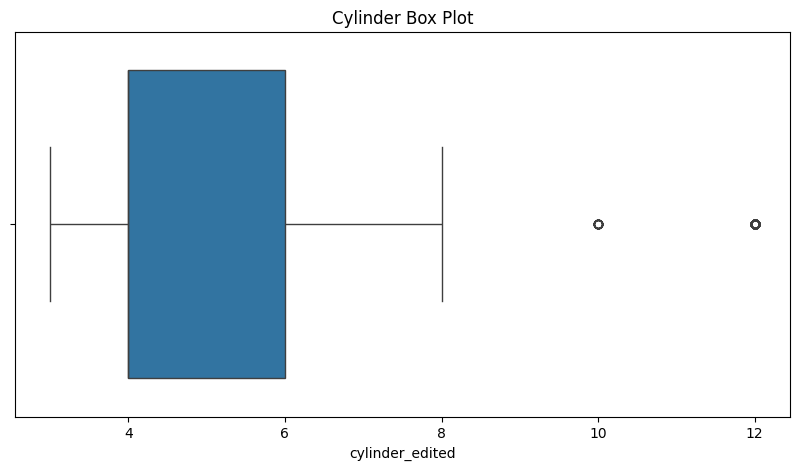

In [32]:
# draw box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['cylinder_edited'])
plt.title('Cylinder Box Plot')
plt.show()

In [33]:
# set of cylinder values
car_df['cylinder_edited'].unique()
#accepted

array([ 4.,  6., 12.,  8., nan,  3.,  5., 10.])

In [34]:
car_df.head()

,car name,horse_power,top_speed,seats,brand,country,price_usd,engine_capacity_edited,cylinder_edited
1,Peugeot Traveller 2021 L3 VIP,180,8 Seater,8.8,peugeot,ksa,37486.667,2000.0,4.0
2,Suzuki Jimny 2021 1.5L Automatic,102,145,4 Seater,suzuki,ksa,26342.667,1500.0,4.0
3,Ford Bronco 2021 2.3T Big Bend,420,4 Seater,7.5,ford,ksa,52800.000,2300.0,4.0
5,Honda HR-V 2021 1.8 i-VTEC EX,140,190,5 Seater,honda,ksa,25422.667,1800.0,4.0
6,Peugeot Expert 2021 Van L3 A/T,120,170,N A,peugeot,ksa,22092.000,2000.0,4.0


In [35]:
hourses = []

for horse in car_df['horse_power']:
    try:
        horse = int(horse)
        if horse <= 0:
            hourses.append(np.nan)
        else:
            hourses.append(horse)
    except ValueError:
        hourses.append(np.nan)

car_df['horse_power_edited'] = hourses
car_df.drop('horse_power', axis=1, inplace=True)

In [36]:
car_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4932 entries, 1 to 6306
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                4932 non-null   object 
 1   top_speed               4932 non-null   object 
 2   seats                   4932 non-null   object 
 3   brand                   4932 non-null   object 
 4   country                 4932 non-null   object 
 5   price_usd               4932 non-null   float64
 6   engine_capacity_edited  4932 non-null   float64
 7   cylinder_edited         4401 non-null   float64
 8   horse_power_edited      4915 non-null   float64
dtypes: float64(4), object(5)
memory usage: 385.3+ KB


In [37]:

car_df['horse_power_edited'].describe()

count    4915.000000
mean      282.584741
std       151.033177
min        25.000000
25%       164.000000
50%       248.000000
75%       363.000000
max       900.000000
Name: horse_power_edited, dtype: float64

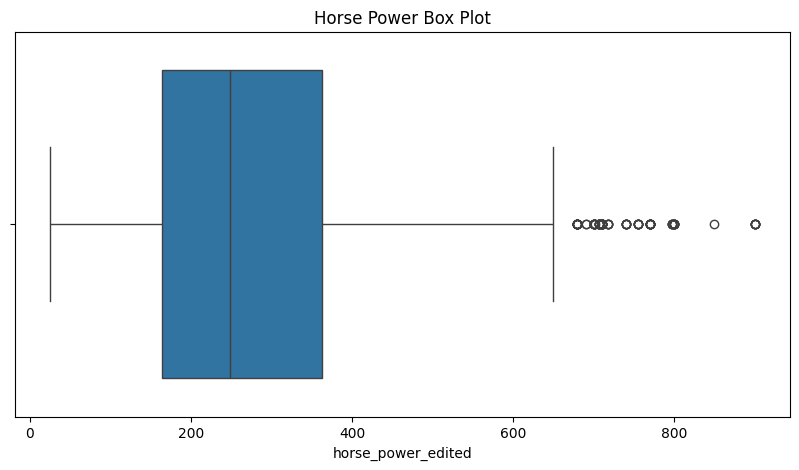

In [38]:
fig = plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['horse_power_edited'])
plt.title('Horse Power Box Plot')
plt.show()

In [39]:
#min horse powwer in 50 and max 2000

car_df = car_df[(car_df['horse_power_edited'] >= 50) & (car_df['horse_power_edited'] <= 2000)]

In [40]:
car_df['horse_power_edited'].describe()

count    4909.000000
mean      282.899572
std       150.856539
min        65.000000
25%       164.000000
50%       248.000000
75%       363.000000
max       900.000000
Name: horse_power_edited, dtype: float64

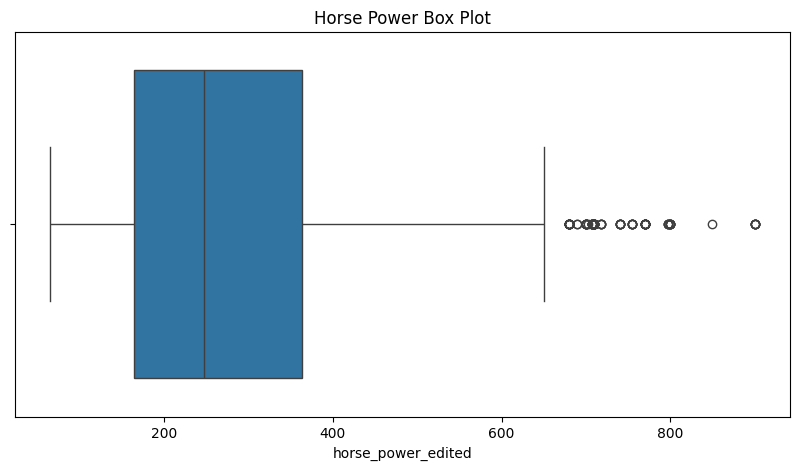

In [41]:
# draw box plot
plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['horse_power_edited'])
plt.title('Horse Power Box Plot')
plt.show()

In [42]:

car_df.head()

,car name,top_speed,seats,brand,country,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited
1,Peugeot Traveller 2021 L3 VIP,8 Seater,8.8,peugeot,ksa,37486.667,2000.0,4.0,180.0
2,Suzuki Jimny 2021 1.5L Automatic,145,4 Seater,suzuki,ksa,26342.667,1500.0,4.0,102.0
3,Ford Bronco 2021 2.3T Big Bend,4 Seater,7.5,ford,ksa,52800.000,2300.0,4.0,420.0
5,Honda HR-V 2021 1.8 i-VTEC EX,190,5 Seater,honda,ksa,25422.667,1800.0,4.0,140.0
6,Peugeot Expert 2021 Van L3 A/T,170,N A,peugeot,ksa,22092.000,2000.0,4.0,120.0


In [43]:
top_speeds = []

for speed in car_df['top_speed']:
    try:
        speed = int(speed)
        if speed <= 0:
            top_speeds.append(np.nan)
        else:
            top_speeds.append(speed)
    except ValueError:
        top_speeds.append(np.nan)

car_df['top_speed_edited'] = top_speeds
car_df.drop('top_speed', axis=1, inplace=True)

In [44]:

car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 1 to 6306
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                4909 non-null   object 
 1   seats                   4909 non-null   object 
 2   brand                   4909 non-null   object 
 3   country                 4909 non-null   object 
 4   price_usd               4909 non-null   float64
 5   engine_capacity_edited  4909 non-null   float64
 6   cylinder_edited         4378 non-null   float64
 7   horse_power_edited      4909 non-null   float64
 8   top_speed_edited        4663 non-null   float64
dtypes: float64(5), object(4)
memory usage: 383.5+ KB


In [45]:
car_df['top_speed_edited'].describe()

count    4663.000000
mean      221.069269
std        41.815007
min       120.000000
25%       185.000000
50%       215.000000
75%       250.000000
max       350.000000
Name: top_speed_edited, dtype: float64

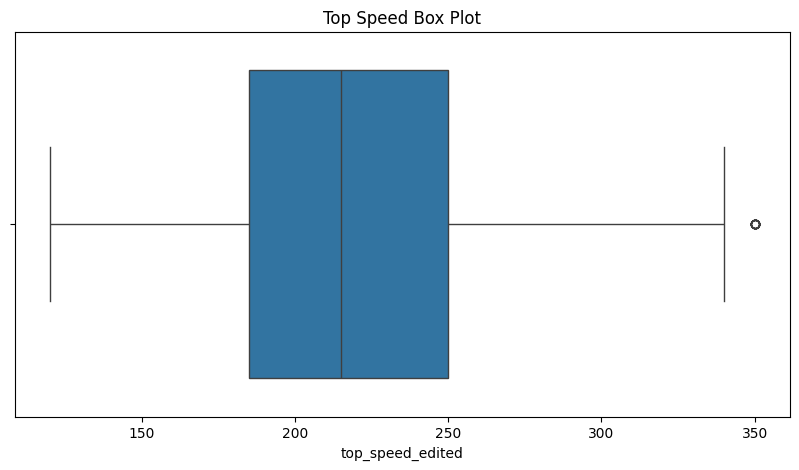

In [46]:

fig = plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['top_speed_edited'])
plt.title('Top Speed Box Plot')
plt.show()

no real outliers in the speed

In [47]:

car_df.head()


,car name,seats,brand,country,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited
1,Peugeot Traveller 2021 L3 VIP,8.8,peugeot,ksa,37486.667,2000.0,4.0,180.0,NaN
2,Suzuki Jimny 2021 1.5L Automatic,4 Seater,suzuki,ksa,26342.667,1500.0,4.0,102.0,145.0
3,Ford Bronco 2021 2.3T Big Bend,7.5,ford,ksa,52800.000,2300.0,4.0,420.0,NaN
5,Honda HR-V 2021 1.8 i-VTEC EX,5 Seater,honda,ksa,25422.667,1800.0,4.0,140.0,190.0
6,Peugeot Expert 2021 Van L3 A/T,N A,peugeot,ksa,22092.000,2000.0,4.0,120.0,170.0


In [48]:
seats = []

for seat in car_df['seats']:
    try:
        # Try to convert seat directly to an integer
        seat = int(seat)
    except ValueError:
        try:
            # If direct conversion fails, split by space and convert the first part
            seat = int(seat.split(' ')[0])
        except ValueError:
            # If conversion still fails, append NaN
            seats.append(np.nan)
            continue
        
    # Append NaN if seat is less than or equal to 0, otherwise append the seat value
    if seat <= 0:
        seats.append(np.nan)
    else:
        seats.append(seat)

# Add the new column to the DataFrame
car_df['seats_edited'] = seats
# Drop the original 'seats' column
car_df.drop('seats', axis=1, inplace=True)

In [49]:

car_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 1 to 6306
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                4909 non-null   object 
 1   brand                   4909 non-null   object 
 2   country                 4909 non-null   object 
 3   price_usd               4909 non-null   float64
 4   engine_capacity_edited  4909 non-null   float64
 5   cylinder_edited         4378 non-null   float64
 6   horse_power_edited      4909 non-null   float64
 7   top_speed_edited        4663 non-null   float64
 8   seats_edited            4612 non-null   float64
dtypes: float64(6), object(3)
memory usage: 383.5+ KB


In [50]:

car_df['seats_edited'].describe()

count    4612.000000
mean        4.939722
std         1.529671
min         2.000000
25%         4.000000
50%         5.000000
75%         5.000000
max        18.000000
Name: seats_edited, dtype: float64

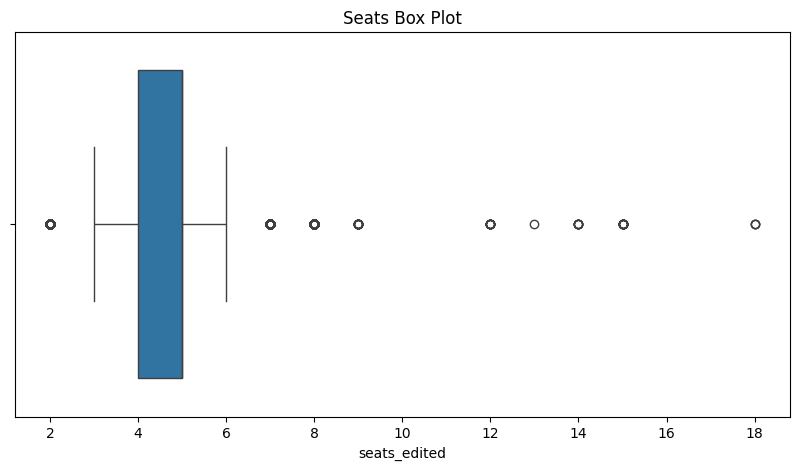

In [51]:

fig = plt.figure(figsize=(10, 5))
sns.boxplot(x=car_df['seats_edited'])
plt.title('Seats Box Plot')
plt.show()

In [52]:
#show the car where seat >10
car_df[car_df['seats_edited'] > 10].sort_values('seats_edited', ascending=False)

,car name,brand,country,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited,seats_edited
1722,Maxus V80 18-Seater 2021 2.5L Passenger Van (M/T),maxus,bahrain,27851.459,2500.0,4.0,136.0,150.0,18.0
3488,Maxus V80 18-Seater 2021 2.5L Passenger Van (M/T),maxus,oman,27083.333,2500.0,4.0,136.0,150.0,18.0
2591,Maxus V80 18-Seater 2021 2.5L Passenger Van (M/T),maxus,qatar,28296.703,2500.0,4.0,136.0,150.0,18.0
79,Great Wall Wingle 7 2021 2.0T Double Cabin (4x4),great-wall,ksa,19311.733,2000.0,4.0,315.0,NaN,15.0
5216,Great Wall Wingle 7 2021 2.0T Double Cabin (4x4),great-wall,uae,15765.827,2000.0,4.0,315.0,NaN,15.0
3399,Maxus V80 15-Seater 2021 2.5L Passenger Van (M/T),maxus,oman,20312.500,2500.0,4.0,136.0,160.0,15.0
85,Great Wall Wingle 7 2021 2.0T Single Cabin (RWD),great-wall,ksa,17165.067,2000.0,4.0,315.0,NaN,15.0
5222,Great Wall Wingle 7 2021 2.4T Double Cabin (4x...,great-wall,uae,15765.827,2400.0,4.0,220.0,NaN,15.0
2522,King Long Wide Body Passenger Van 2021 2.7L (1...,kinglong,qatar,24175.824,2700.0,4.0,148.0,156.0,15.0
2485,Maxus V80 15-Seater 2021 2.5L Passenger Van (M/T),maxus,qatar,21703.297,2500.0,4.0,136.0,160.0,15.0


In [53]:
# show country as a set
car_df['country'].unique()

array(['ksa', 'egypt', 'bahrain', 'qatar', 'oman', 'kuwait', 'uae'],
      dtype=object)

In [54]:
car_df.head()

,car name,brand,country,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited,seats_edited
1,Peugeot Traveller 2021 L3 VIP,peugeot,ksa,37486.667,2000.0,4.0,180.0,NaN,NaN
2,Suzuki Jimny 2021 1.5L Automatic,suzuki,ksa,26342.667,1500.0,4.0,102.0,145.0,4.0
3,Ford Bronco 2021 2.3T Big Bend,ford,ksa,52800.000,2300.0,4.0,420.0,NaN,NaN
5,Honda HR-V 2021 1.8 i-VTEC EX,honda,ksa,25422.667,1800.0,4.0,140.0,190.0,5.0
6,Peugeot Expert 2021 Van L3 A/T,peugeot,ksa,22092.000,2000.0,4.0,120.0,170.0,NaN


data is cleaned 
remaianing  missing values

In [55]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 1 to 6306
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   car name                4909 non-null   object 
 1   brand                   4909 non-null   object 
 2   country                 4909 non-null   object 
 3   price_usd               4909 non-null   float64
 4   engine_capacity_edited  4909 non-null   float64
 5   cylinder_edited         4378 non-null   float64
 6   horse_power_edited      4909 non-null   float64
 7   top_speed_edited        4663 non-null   float64
 8   seats_edited            4612 non-null   float64
dtypes: float64(6), object(3)
memory usage: 383.5+ KB


encode 

In [56]:


# Create an instance of the LabelEncoder
le = LabelEncoder()

# # Fit the encoder
# le.fit(df['gender'])

# # Transform
# df_enc = le.transform(df['gender'])

# # Create a copy of the original DataFrame to store the encoded data
# df_labelenc = df.copy()

# # Add the encoded column to the new DataFrame

# df_labelenc[le.classes_[0]] = df_enc

# # Display the first few rows of the new DataFrame
# df_labelenc.head()

for col in car_df.columns:
    if car_df[col].dtype == 'object':
        car_df[col] = le.fit_transform(car_df[col])
        

In [57]:
car_df.describe()

,car name,brand,country,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited,seats_edited
count,4909.000000,4909.000000,4909.000000,4.909000e+03,4909.000000,4378.000000,4909.000000,4663.000000,4612.000000
mean,1033.519861,40.545529,3.289672,6.959403e+04,2811.891017,5.314299,282.899572,221.069269,4.939722
std,606.021508,21.809266,2.022998,7.819286e+04,1282.476675,1.900274,150.856539,41.815007,1.529671
min,0.000000,0.000000,0.000000,4.765056e+03,999.000000,3.000000,65.000000,120.000000,2.000000
25%,466.000000,24.000000,2.000000,2.564610e+04,2000.000000,4.000000,164.000000,185.000000,4.000000
50%,1103.000000,45.000000,3.000000,4.725040e+04,2500.000000,4.000000,248.000000,215.000000,5.000000
75%,1522.000000,58.000000,5.000000,8.222812e+04,3500.000000,6.000000,363.000000,250.000000,5.000000
max,2108.000000,77.000000,6.000000,1.489777e+06,6800.000000,12.000000,900.000000,350.000000,18.000000


In [58]:
print("number of missing data in each feature")
car_df.isna().sum()


number of missing data in each feature


car name                    0
brand                       0
country                     0
price_usd                   0
engine_capacity_edited      0
cylinder_edited           531
horse_power_edited          0
top_speed_edited          246
seats_edited              297
dtype: int64

In [59]:
for i in range(1,car_df.shape[1]):
    print(f"Number of records that have {i} missing values: {car_df[car_df.isna().sum(axis=1) == i].shape[0]}")

Number of records that have 1 missing values: 592
Number of records that have 2 missing values: 217
Number of records that have 3 missing values: 16
Number of records that have 4 missing values: 0
Number of records that have 5 missing values: 0
Number of records that have 6 missing values: 0
Number of records that have 7 missing values: 0
Number of records that have 8 missing values: 0


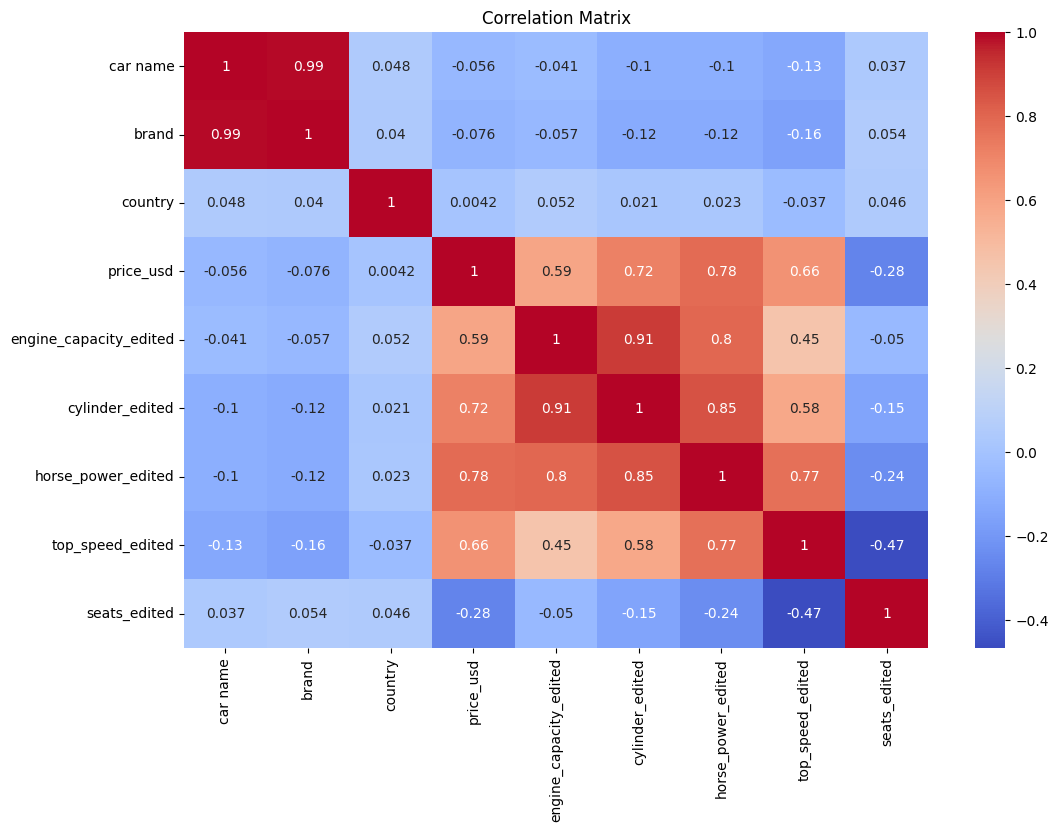

In [60]:
# make correlation matrix
corr = car_df.corr()

# plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

top speed -> hourse power

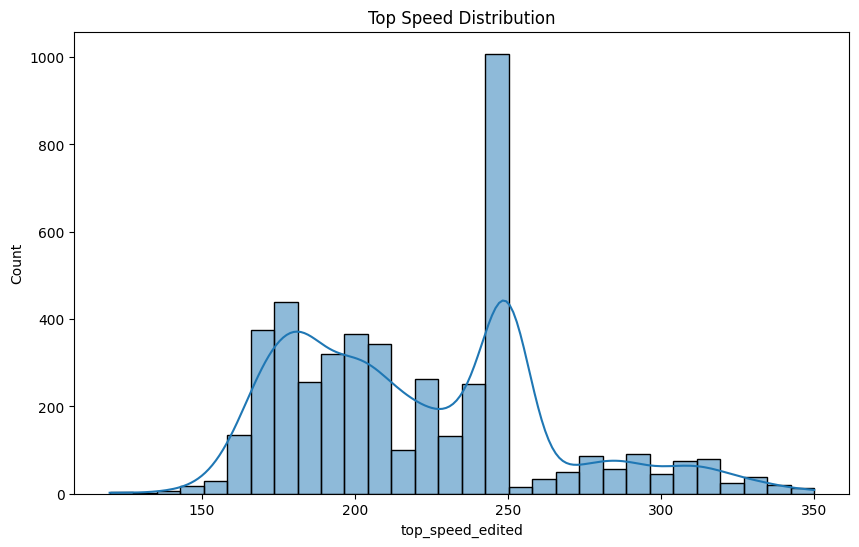

In [61]:
# draw histogram for top speed
plt.figure(figsize=(10, 6))
sns.histplot(car_df['top_speed_edited'], kde=True)
plt.title('Top Speed Distribution')
plt.show()

In [62]:
# handle missing top_speed_edited values via hourse_power_edited
#  because they are highly correlated

car_df['top_speed_edited'] = car_df['top_speed_edited'].fillna(car_df.groupby('horse_power_edited')['top_speed_edited'].transform('mean'))



In [63]:
car_df.isna().sum()


car name                    0
brand                       0
country                     0
price_usd                   0
engine_capacity_edited      0
cylinder_edited           531
horse_power_edited          0
top_speed_edited           47
seats_edited              297
dtype: int64

In [64]:
car_df['top_speed_edited'].fillna(car_df['top_speed_edited'].mean(), inplace=True) # fill the remaining missing values with the mean

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16184\148539906.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  car_df['top_speed_edited'].fillna(car_df['top_speed_edited'].mean(), inplace=True) # fill the remaining missing values with the mean


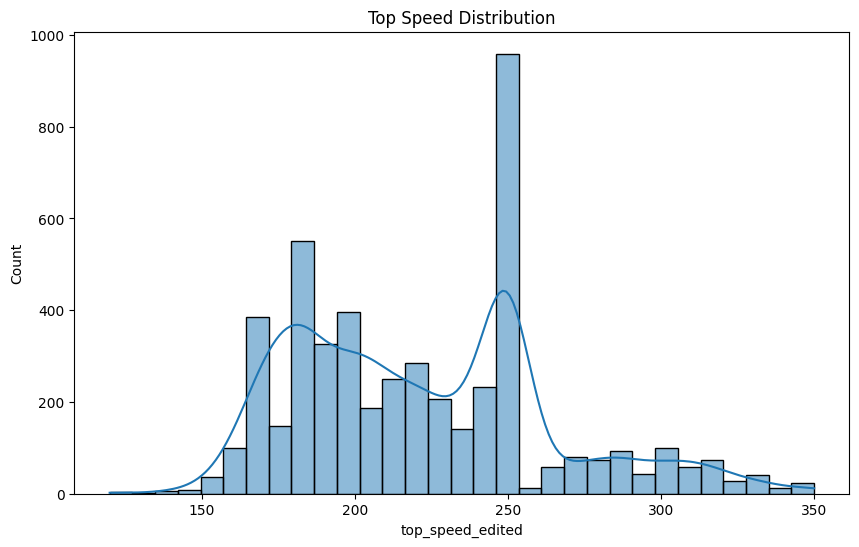

In [65]:

# draw histogram for top speed
plt.figure(figsize=(10, 6))
sns.histplot(car_df['top_speed_edited'], kde=True)
plt.title('Top Speed Distribution')
plt.show()


cyliners -> engine size

In [66]:
car_df['cylinder_edited'] = car_df['cylinder_edited'].fillna(
    car_df.groupby('engine_capacity_edited')['cylinder_edited'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)


In [67]:
car_df.isna().sum()    

car name                    0
brand                       0
country                     0
price_usd                   0
engine_capacity_edited      0
cylinder_edited             1
horse_power_edited          0
top_speed_edited            0
seats_edited              297
dtype: int64

In [68]:

car_df['cylinder_edited'].fillna(car_df['cylinder_edited'].mode()[0], inplace=True) # fill the remaining missing values with the mode

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16184\349120942.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  car_df['cylinder_edited'].fillna(car_df['cylinder_edited'].mode()[0], inplace=True) # fill the remaining missing values with the mode


In [69]:

car_df.isna().sum()

car name                    0
brand                       0
country                     0
price_usd                   0
engine_capacity_edited      0
cylinder_edited             0
horse_power_edited          0
top_speed_edited            0
seats_edited              297
dtype: int64

seats not highly correlated with any other feature so impute with mode

In [70]:

car_df['seats_edited'] = car_df['seats_edited'].fillna(car_df['seats_edited'].mode()[0]) # fill the missing values with the mode

In [71]:
car_df.isna().sum()


car name                  0
brand                     0
country                   0
price_usd                 0
engine_capacity_edited    0
cylinder_edited           0
horse_power_edited        0
top_speed_edited          0
seats_edited              0
dtype: int64

In [ ]:
# make z score for scaling the data

car_df_scaled = car_df.apply(zscore)

car_df_scaled.head()

,car name,brand,country,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited,seats_edited
1,1.022312,0.892119,-0.63757,-0.410659,-0.633129,-0.689665,-0.682172,-0.175341,0.038197
2,1.358968,1.396543,-0.63757,-0.553193,-1.023040,-0.689665,-1.199272,-1.833816,-0.636301
3,-0.939864,-0.758724,-0.63757,-0.214799,-0.399183,-0.689665,0.908906,-0.016441,0.038197
5,-0.664268,-0.437727,-0.63757,-0.564960,-0.789094,-0.689665,-0.947351,-0.764772,0.038197
6,1.010760,0.892119,-0.63757,-0.607560,-0.633129,-0.689665,-1.079941,-1.239903,0.038197


In [78]:
car_df_scaled.describe()

,car name,brand,country,price_usd,engine_capacity_edited,cylinder_edited,horse_power_edited,top_speed_edited,seats_edited
count,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03,4.909000e+03
mean,2.605372e-17,1.186892e-16,-1.389532e-16,1.765863e-16,1.736914e-16,1.968503e-16,-1.794812e-16,-3.329086e-16,-7.381886e-17
std,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00
min,-1.705592e+00,-1.859286e+00,-1.626303e+00,-8.291752e-01,-1.413730e+00,-1.220068e+00,-1.444563e+00,-2.427730e+00,-1.985297e+00
25%,-9.365636e-01,-7.587240e-01,-6.375704e-01,-5.621025e-01,-6.331294e-01,-6.896646e-01,-7.882435e-01,-8.835548e-01,3.819728e-02
50%,1.146613e-01,2.042675e-01,-1.432041e-01,-2.857794e-01,-2.432191e-01,-6.896646e-01,-2.313664e-01,-5.207583e-02,3.819728e-02
75%,8.061263e-01,8.004052e-01,8.455285e-01,1.615924e-01,5.366016e-01,3.711418e-01,5.310250e-01,6.606204e-01,3.819728e-02
max,1.773187e+00,1.671683e+00,1.339895e+00,1.816442e+01,3.110010e+00,3.553561e+00,4.091061e+00,3.036275e+00,8.806671e+00


make a comparosion between scaled and unscaled data

there is so much different

In [93]:
X = car_df_scaled.drop('price_usd', axis=1)
y = car_df_scaled['price_usd']
#Split the dataset into training, validation, and test sets. A common split would be
#60% for training, 20% for validation, and 20% for testing.


# Initial split: 80% for training/validation and 20% for testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Split the 80% training/validation into 60% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Now you have 60% training, 20% validation, and 20% test sets


In [99]:
# make regrission model with closed form solution (XT X)-1 XT y
def closed_form_solution(X, y):
    X_T = X.T
    X_T_dot_X = X_T.dot(X)
    X_T_dot_X_inv = np.linalg.inv(X_T_dot_X)
    X_T_dot_y = X_T.dot(y)
    return X_T_dot_X_inv.dot(X_T_dot_y)

# make prediction
def predict(X, w):
    return w.transpose().dot(X)

# make R score for evaluation
def r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    SS_res = np.sum((y_true - y_pred) ** 2)
    SS_tot = np.sum((y_true - y_mean) ** 2)
    return 1 - (SS_res / SS_tot)


linear regression

In [104]:
w = closed_form_solution(X_train, y_train)
for i in range(X_train.shape[1]):
    print(f'w{i} = {w[i]}')

print('\n=======================================\n')

y_pred = X_val.dot(w)
r2 = r_squared(y_val, y_pred)
print(f'R^2: {r2}')

w0 = 0.27559465088923485
w1 = -0.22979692825389986
w2 = 0.022297571545787875
w3 = -0.43297664786699563
w4 = 0.6027704981219797
w5 = 0.514514836620779
w6 = 0.09378870309176834
w7 = -0.04444690571500021


R^2: 0.7842435869634337


In [110]:
#ridge regression
def ridge_regression(X, y, lambda_):
    I = np.identity(X.shape[1])
    w = np.linalg.inv(X.T.dot(X) + lambda_ * I).dot(X.T).dot(y)
    return w

lambdas = [0.0001, 0.01, 0.1,1, 10, 100, 1000]
#apply grid search
best_lambda = None
best_r2 = -np.inf

for lambda_ in lambdas:
    w = ridge_regression(X_train, y_train, lambda_)
    y_pred = X_val.dot(w)
    r2 = r_squared(y_val, y_pred)
    print(f'Lambda: {lambda_}, R^2: {r2}')
    if r2 > best_r2:
        best_r2 = r2
        best_lambda = lambda_

print(f'\nBest Lambda: {best_lambda}, Best R^2: {best_r2}')


Lambda: 0.0001, R^2: 0.784243571796721
Lambda: 0.01, R^2: 0.7842420706090841
Lambda: 0.1, R^2: 0.7842284521577964
Lambda: 1, R^2: 0.784095036830734
Lambda: 10, R^2: 0.7829715552275435
Lambda: 100, R^2: 0.7753380326608489
Lambda: 1000, R^2: 0.7340216646696012

Best Lambda: 0.0001, Best R^2: 0.784243571796721


non linear regression

In [101]:
def polynomial_features(X, degree):
    n_samples, n_features = X.shape
    X_poly = np.ones((n_samples, 1))  # Start with the bias term (column of ones)
    
    # Generate polynomial terms up to the specified degree
    for d in range(1, degree + 1):
        for item in combinations_with_replacement(range(n_features), d):
            term = np.prod([X[:, j] for j in item], axis=0).reshape(-1, 1)
            X_poly = np.hstack((X_poly, term))
    
    return X_poly


In [102]:

# make polynomial features
r2_poly = []
for degree in range(2, 6):
    X_train_poly = polynomial_features(X_train.values, degree)
    X_val_poly = polynomial_features(X_val.values, degree)
    
    w = closed_form_solution(X_train_poly, y_train)
    print(f'Degree: {degree}')
    print(f"{len(w)} weights")
    y_pred = X_val_poly.dot(w)
    r2 = r_squared(y_val, y_pred)
    r2_poly.append((degree, r2))
    print(f'Degree: {degree}, R^2: {r2}\n')



Degree: 2
45 weights
Degree: 2, R^2: 0.8589835246120332

Degree: 3
165 weights
Degree: 3, R^2: 0.8849499734020556

Degree: 4
495 weights
Degree: 4, R^2: 0.2225201923950194

Degree: 5
1287 weights
Degree: 5, R^2: -103.65880896799021



In [ ]:

# not sure

# Radial Basis 

def radial_basis_function(X, centers, gamma):
    n_samples = X.shape[0]
    n_centers = centers.shape[0]
    X_rbf = np.ones((n_samples, 1))  # Start with the bias term (column of ones)
    
    for i in range(n_centers):
        center = centers[i]
        rbf = np.exp(-gamma * np.linalg.norm(X - center, axis=1) ** 2).reshape(-1, 1)
        X_rbf = np.hstack((X_rbf, rbf))
    
    return X_rbf

# make radial basis function
r2_rbf = []
for gamma in [0.01, 0.1, 1, 10, 100]:
    for n_centers in [10, 20, 30, 40, 50]:
        centers = X_train.sample(n=n_centers, random_state=42).values
        X_train_rbf = radial_basis_function(X_train.values, centers, gamma)
        X_val_rbf = radial_basis_function(X_val.values, centers, gamma)
        
        w = closed_form_solution(X_train_rbf, y_train)
        print(f'Gamma: {gamma}, Number of centers: {n_centers}')
        print(f"{len(w)} weights")
        y_pred = X_val_rbf.dot(w)
        r2 = r_squared(y_val, y_pred)
        r2_rbf.append((gamma, n_centers, r2))
        print(f'R^2: {r2}\n')




Gamma: 0.01, Number of centers: 10
11 weights
R^2: 0.7809642144149812

Gamma: 0.01, Number of centers: 20
21 weights
R^2: 0.8374230395068636

Gamma: 0.01, Number of centers: 30
31 weights
R^2: 0.8633239534758566

Gamma: 0.01, Number of centers: 40
41 weights
R^2: 0.8405282555705886

Gamma: 0.01, Number of centers: 50
51 weights
R^2: 0.848766021032617

Gamma: 0.1, Number of centers: 10
11 weights
R^2: 0.5593704379497821

Gamma: 0.1, Number of centers: 20
21 weights
R^2: 0.6514614260354347

Gamma: 0.1, Number of centers: 30
31 weights
R^2: 0.6732022982085673

Gamma: 0.1, Number of centers: 40
41 weights
R^2: 0.7503700793036657

Gamma: 0.1, Number of centers: 50
51 weights
R^2: 0.7631661931716909

Gamma: 1, Number of centers: 10
11 weights
R^2: 0.1009543099845499

Gamma: 1, Number of centers: 20
21 weights
R^2: 0.19798908229839463

Gamma: 1, Number of centers: 30
31 weights
R^2: 0.25358317934646457

Gamma: 1, Number of centers: 40
41 weights
R^2: 0.350490847955532

Gamma: 1, Number of cen